# Experiment 3: Gaussian Process Regression (5D)

This notebook extends the GPR experiments to 5 dimensions using standard benchmark test functions.

**Test Functions:**
1. **Friedman function** - A standard regression benchmark
2. **Sum of Gaussians** - Multiple local features

**Comparison:** Korobov, Explicit rank-1, Random, Halton, Sobol point sets

## Setup

In [42]:
# Uncomment for Google Colab
# !pip install numpy scipy matplotlib qmcpy scikit-learn

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from math import gcd
from functools import reduce
from typing import List, Tuple, Optional, Callable
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn for GPR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

# Import from lattice_qmc package
from lattice_qmc import KorobovLattice, ExplicitRank1Lattice
from lattice_qmc.utils import generate_primes, compute_separation_radius_fast


# QMCPy for Halton and Sobol
try:
    import qmcpy as qp
    QMCPY_AVAILABLE = True
    print("QMCPy loaded successfully.")
except ImportError:
    QMCPY_AVAILABLE = False
    print("QMCPy not available.")

# Publication-quality plot settings
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10,
    'figure.figsize': (10, 7),
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

np.random.seed(42)
print("Setup complete!")

QMCPy loaded successfully.
Setup complete!


## Helper Functions for Other Point Sets

In [46]:
# ============================================================
# Other Point Set Generators
# ============================================================

def generate_random_points(n: int, d: int, seed: int = None) -> np.ndarray:
    if seed is not None:
        np.random.seed(seed)
    return np.random.rand(n, d)

def generate_halton_points(n: int, d: int) -> np.ndarray:
    if not QMCPY_AVAILABLE:
        raise ImportError("QMCPy required.")
    halton = qp.Halton(d, seed=42)
    return halton.gen_samples(n)

def generate_sobol_points(n: int, d: int) -> np.ndarray:
    if not QMCPY_AVAILABLE:
        raise ImportError("QMCPy required.")
    sobol = qp.Sobol(d, seed=42)
    return sobol.gen_samples(n)

print("Point set generators loaded.")

Point set generators loaded.


---

## Part 1: 5D Test Functions

### 1.1 Franke-like Function (5D)

An extension of the **Franke function** to 5D, preserving its key characteristics:
- Multiple Gaussian peaks (positive contributions)
- Gaussian valleys (negative contributions)  
- Varying widths and amplitudes

$$
f(x) = \frac{3}{4} e^{-\frac{\|9x - 2\mathbf{1}\|^2}{16}} + \frac{3}{4} e^{-\frac{(9x_1+1)^2}{196} - \frac{\|9x_{2:5}+1\mathbf{1}\|^2}{40}} + \frac{1}{2} e^{-\frac{\|9x - c_3\|^2}{16}} - \frac{1}{5} e^{-\|9x - c_4\|^2}
$$

In [64]:
def franke_5d(X: np.ndarray) -> np.ndarray:
    """
    Franke-like test function extended to 5D.
    
    Preserves the key characteristics of the 2D Franke function:
    - Multiple Gaussian peaks (positive)
    - A Gaussian valley (negative)
    - Varying widths and positions
    
    Parameters
    ----------
    X : np.ndarray
        Points of shape (n, 5) in [0, 1]^5.
    
    Returns
    -------
    np.ndarray
        Function values of shape (n,).
    """
    # Scale to [0, 9] like the original Franke function
    Y = 9 * X
    
    # Term 1: Gaussian peak near (2/9, 2/9, ..., 2/9)
    center1 = 2.0 * np.ones(5)
    dist1_sq = np.sum((Y - center1)**2, axis=1)
    term1 = 0.75 * np.exp(-dist1_sq / 16)
    
    # Term 2: Elongated Gaussian (different scales in different dimensions)
    # Similar to the 2D Franke's second term with (9x+1)^2/49 and (9y+1)/10
    term2_part1 = (Y[:, 0] + 1)**2 / 196  # narrow in x1
    term2_part2 = np.sum((Y[:, 1:] + 1)**2, axis=1) / 160  # wider in other dims
    term2 = 0.75 * np.exp(-term2_part1 - term2_part2)
    
    # Term 3: Gaussian peak near (7/9, 3/9, 5/9, 5/9, 5/9)
    center3 = np.array([7.0, 3.0, 5.0, 5.0, 5.0])
    dist3_sq = np.sum((Y - center3)**2, axis=1)
    term3 = 0.5 * np.exp(-dist3_sq / 16)
    
    # Term 4: Negative Gaussian (valley) near (4/9, 7/9, 5/9, 3/9, 6/9)
    center4 = np.array([4.0, 7.0, 5.0, 3.0, 6.0])
    dist4_sq = np.sum((Y - center4)**2, axis=1)
    term4 = -0.2 * np.exp(-dist4_sq / 4)
    
    return term1 + term2 + term3 + term4


# Test
test_pts = np.array([[0.5]*5, [0.0]*5, [1.0]*5, [2/9]*5])
print("Franke 5D function values:")
print(franke_5d(test_pts))

Franke 5D function values:
[0.67655235 0.9427612  0.03900477 1.34022135]


### 1.2 Friedman Function

The **Friedman #1 function** is a standard regression benchmark:

$$
f(x_1, x_2, x_3, x_4, x_5) = 10 \sin(\pi x_1 x_2) + 20 (x_3 - 0.5)^2 + 10 x_4 + 5 x_5
$$

This function features:
- Nonlinear interaction between $x_1$ and $x_2$
- Quadratic dependence on $x_3$
- Linear dependence on $x_4$ and $x_5$

In [65]:
def friedman_function(X: np.ndarray) -> np.ndarray:
    """
    Friedman #1 test function for 5D regression.
    
    f(x) = 10*sin(π*x1*x2) + 20*(x3-0.5)² + 10*x4 + 5*x5
    
    Parameters
    ----------
    X : np.ndarray
        Points of shape (n, 5) in [0, 1]^5.
    
    Returns
    -------
    np.ndarray
        Function values of shape (n,).
    """
    x1, x2, x3, x4, x5 = X[:, 0], X[:, 1], X[:, 2], X[:, 3], X[:, 4]
    
    term1 = 10 * np.sin(np.pi * x1 * x2)
    term2 = 20 * (x3 - 0.5)**2
    term3 = 10 * x4
    term4 = 5 * x5
    
    return term1 + term2 + term3 + term4


print("Friedman function values:")
print(friedman_function(test_pts))

Friedman function values:
[14.57106781  5.         20.          6.42173114]


---

## Part 2: GPR Implementation for 5D

In [66]:
def fit_gpr(X_train: np.ndarray, y_train: np.ndarray, 
            length_scale: float = 0.3, alpha: float = 1e-6) -> GaussianProcessRegressor:
    """
    Fit a Gaussian Process Regressor.
    """
    kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=length_scale, 
                                           length_scale_bounds=(1e-2, 1e1),
                                           nu=2.5)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, 
                                   n_restarts_optimizer=3,
                                   normalize_y=True)
    gpr.fit(X_train, y_train)
    return gpr


def compute_l2_error_mc(gpr: GaussianProcessRegressor, 
                        true_func: Callable,
                        d: int,
                        n_mc: int = 10000,
                        seed: int = 12345) -> float:
    """
    Compute L² error using Monte Carlo integration.
    
    For high dimensions, MC is more practical than tensor product quadrature.
    
    ||f - f_GPR||_{L²}² ≈ (1/n) Σ |f(x_i) - f_GPR(x_i)|²
    
    Parameters
    ----------
    gpr : GaussianProcessRegressor
        Fitted GPR model.
    true_func : Callable
        True function.
    d : int
        Dimension.
    n_mc : int
        Number of Monte Carlo samples.
    seed : int
        Random seed for reproducibility.
    
    Returns
    -------
    float
        Estimated L² error.
    """
    # Use pure Monte Carlo (random points)
    np.random.seed(seed)
    X_mc = np.random.rand(n_mc, d)
    
    # Evaluate
    f_true = true_func(X_mc)
    f_gpr = gpr.predict(X_mc)
    
    # L² error (MC estimate)
    l2_error_sq = np.mean((f_true - f_gpr)**2)
    return np.sqrt(l2_error_sq)


# Configuration for noisy observations
NOISE_STD = 0.05  # Standard deviation of observation noise
N_TRIALS = 100    # Number of Monte Carlo trials

print("GPR functions for 5D loaded.")
print(f"Noise std: {NOISE_STD}, Number of trials: {N_TRIALS}")

GPR functions for 5D loaded.
Noise std: 0.05, Number of trials: 100


---

## Part 3: Run Experiments

### 3.1 Configuration

In [67]:
d = 5

# Point counts for each method
# For 5D, we need more points but computation is heavier
korobov_primes_5d = [17, 31, 67, 127, 257, 509]
explicit_m_values_5d = list(range(3, 9))
sobol_powers_5d = [16, 32, 64, 128, 256, 512]
halton_random_n_5d = [16, 32, 64, 128, 256, 512]

print(f"Configuration for d = {d}:")
print(f"  Korobov primes: {korobov_primes_5d}")
print(f"  Explicit m values: {explicit_m_values_5d}")
print(f"  Sobol powers: {sobol_powers_5d}")

Configuration for d = 5:
  Korobov primes: [17, 31, 67, 127, 257, 509]
  Explicit m values: [3, 4, 5, 6, 7, 8]
  Sobol powers: [16, 32, 64, 128, 256, 512]


### 3.2 Run Experiment Function

In [68]:
def run_gpr_experiment_5d(test_func: Callable, func_name: str, n_trials: int = N_TRIALS):
    """
    Run GPR experiment for all point set types in 5D with noisy observations.
    Each configuration is run n_trials times with different noise realizations.
    """
    results = {
        'korobov': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
        'explicit': {'N': [], 'l2_error_mean': [], 'l2_error_std': [], 'm': []},
        'random': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
        'halton': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
        'sobol': {'N': [], 'l2_error_mean': [], 'l2_error_std': []},
    }
    
    d = 5
    print(f"\n{'='*60}")
    print(f"GPR Experiment: {func_name} (d = {d})")
    print(f"Noise std: {NOISE_STD}, Trials: {n_trials}")
    print(f"{'='*60}")
    
    # Korobov lattices
    print("\nKorobov lattices:")
    for N in korobov_primes_5d:
        print(f"  N = {N}: ", end="", flush=True)
        lattice = KorobovLattice(d=d, N=N)
        X_train = lattice.points
        y_true = test_func(X_train)
        
        errors = []
        for trial in range(n_trials):
            np.random.seed(1000 + trial)
            y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
            gpr = fit_gpr(X_train, y_noisy)
            l2_error = compute_l2_error_mc(gpr, test_func, d=d)
            errors.append(l2_error)
        
        results['korobov']['N'].append(N)
        results['korobov']['l2_error_mean'].append(np.mean(errors))
        results['korobov']['l2_error_std'].append(np.std(errors))
        print(f"L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    # Explicit rank-1 lattices
    print("\nExplicit rank-1 lattices:")
    for m in explicit_m_values_5d:
        print(f"  m = {m}: ", end="", flush=True)
        lattice = ExplicitRank1Lattice(d=d, m=m)
        X_train = lattice.points
        y_true = test_func(X_train)
        
        errors = []
        for trial in range(n_trials):
            np.random.seed(1000 + trial)
            y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
            gpr = fit_gpr(X_train, y_noisy)
            l2_error = compute_l2_error_mc(gpr, test_func, d=d)
            errors.append(l2_error)
        
        results['explicit']['N'].append(lattice.Q)
        results['explicit']['l2_error_mean'].append(np.mean(errors))
        results['explicit']['l2_error_std'].append(np.std(errors))
        results['explicit']['m'].append(m)
        print(f"Q = {lattice.Q}, L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    # Random points
    print("\nRandom points:")
    for n in halton_random_n_5d:
        print(f"  N = {n}: ", end="", flush=True)
        errors = []
        for trial in range(n_trials):
            np.random.seed(42 + trial)
            X_train = np.random.rand(n, d)
            y_true = test_func(X_train)
            np.random.seed(1000 + trial)
            y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
            gpr = fit_gpr(X_train, y_noisy)
            l2_error = compute_l2_error_mc(gpr, test_func, d=d)
            errors.append(l2_error)
        
        results['random']['N'].append(n)
        results['random']['l2_error_mean'].append(np.mean(errors))
        results['random']['l2_error_std'].append(np.std(errors))
        print(f"L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    # Halton
    if QMCPY_AVAILABLE:
        print("\nHalton sequence:")
        for n in halton_random_n_5d:
            print(f"  N = {n}: ", end="", flush=True)
            X_train = generate_halton_points(n, d)
            y_true = test_func(X_train)
            
            errors = []
            for trial in range(n_trials):
                np.random.seed(1000 + trial)
                y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
                gpr = fit_gpr(X_train, y_noisy)
                l2_error = compute_l2_error_mc(gpr, test_func, d=d)
                errors.append(l2_error)
            
            results['halton']['N'].append(n)
            results['halton']['l2_error_mean'].append(np.mean(errors))
            results['halton']['l2_error_std'].append(np.std(errors))
            print(f"L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
        
        # Sobol
        print("\nSobol sequence:")
        for n in sobol_powers_5d:
            print(f"  N = {n}: ", end="", flush=True)
            X_train = generate_sobol_points(n, d)
            y_true = test_func(X_train)
            
            errors = []
            for trial in range(n_trials):
                np.random.seed(1000 + trial)
                y_noisy = y_true + np.random.normal(0, NOISE_STD, size=y_true.shape)
                gpr = fit_gpr(X_train, y_noisy)
                l2_error = compute_l2_error_mc(gpr, test_func, d=d)
                errors.append(l2_error)
            
            results['sobol']['N'].append(n)
            results['sobol']['l2_error_mean'].append(np.mean(errors))
            results['sobol']['l2_error_std'].append(np.std(errors))
            print(f"L² = {np.mean(errors):.6e} ± {np.std(errors):.6e}")
    
    return results

### 3.3 Run Experiments for Each Test Function

In [69]:
# Experiment 1: Franke 5D function
results_franke = run_gpr_experiment_5d(franke_5d, "Franke 5D")


GPR Experiment: Franke 5D (d = 5)
Noise std: 0.05, Trials: 100

Korobov lattices:
  N = 17: L² = 1.279478e-01 ± 7.076741e-03
  N = 31: L² = 1.279478e-01 ± 7.076741e-03
  N = 31: L² = 1.242545e-01 ± 5.824492e-03
  N = 67: L² = 1.242545e-01 ± 5.824492e-03
  N = 67: L² = 5.718287e-02 ± 4.014503e-03
  N = 127: L² = 5.718287e-02 ± 4.014503e-03
  N = 127: L² = 4.865916e-02 ± 3.712855e-03
  N = 257: L² = 4.865916e-02 ± 3.712855e-03
  N = 257: L² = 4.264512e-02 ± 1.971023e-03
  N = 509: L² = 4.264512e-02 ± 1.971023e-03
  N = 509: L² = 4.051664e-02 ± 1.383864e-03

Explicit rank-1 lattices:
  m = 3: L² = 4.051664e-02 ± 1.383864e-03

Explicit rank-1 lattices:
  m = 3: Q = 15, L² = 1.386764e-01 ± 6.437280e-03
  m = 4: Q = 15, L² = 1.386764e-01 ± 6.437280e-03
  m = 4: Q = 24, L² = 1.210906e-01 ± 6.544218e-03
  m = 5: Q = 24, L² = 1.210906e-01 ± 6.544218e-03
  m = 5: Q = 31, L² = 1.047669e-01 ± 6.961604e-03
  m = 6: Q = 31, L² = 1.047669e-01 ± 6.961604e-03
  m = 6: Q = 65, L² = 9.900865e-02 ± 6.980

In [ ]:
# Experiment 2: Friedman function
results_friedman = run_gpr_experiment_5d(friedman_function, "Friedman")


GPR Experiment: Sum of Gaussians (d = 5)
Noise std: 0.05, Trials: 100

Korobov lattices:
  N = 17: L² = 7.719422e-02 ± 3.501980e-03
  N = 31: L² = 7.719422e-02 ± 3.501980e-03
  N = 31: L² = 7.436818e-02 ± 9.747586e-04
  N = 67: L² = 7.436818e-02 ± 9.747586e-04
  N = 67: L² = 6.456865e-02 ± 2.599636e-03
  N = 127: L² = 6.456865e-02 ± 2.599636e-03
  N = 127: L² = 5.569335e-02 ± 1.793793e-03
  N = 257: L² = 5.569335e-02 ± 1.793793e-03
  N = 257: L² = 4.144690e-02 ± 1.597459e-03
  N = 509: L² = 4.144690e-02 ± 1.597459e-03
  N = 509: L² = 3.771979e-02 ± 1.167737e-03

Explicit rank-1 lattices:
  m = 3: L² = 3.771979e-02 ± 1.167737e-03

Explicit rank-1 lattices:
  m = 3: Q = 15, L² = 7.509462e-02 ± 1.791271e-03
  m = 4: Q = 15, L² = 7.509462e-02 ± 1.791271e-03
  m = 4: Q = 24, L² = 7.907122e-02 ± 6.869644e-03
  m = 5: Q = 24, L² = 7.907122e-02 ± 6.869644e-03
  m = 5: Q = 31, L² = 6.943193e-02 ± 3.775232e-03
  m = 6: Q = 31, L² = 6.943193e-02 ± 3.775232e-03
  m = 6: Q = 65, L² = 6.134678e-02 

---

## Part 4: Visualization

In [70]:
def plot_gpr_results(results: dict, d: int, func_name: str, save_fig: bool = True):
    """
    Plot L² error vs number of points with error bars.
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    
    styles = {
        'korobov': {'color': '#1f77b4', 'marker': 'o', 'label': 'Korobov (ours)'},
        'explicit': {'color': '#d62728', 'marker': 's', 'label': 'Explicit (ours)'},
        'random': {'color': '#7f7f7f', 'marker': 'x', 'label': 'Random'},
        'halton': {'color': '#2ca02c', 'marker': '^', 'label': 'Halton'},
        'sobol': {'color': '#9467bd', 'marker': 'D', 'label': 'Sobol'},
    }
    
    for method, style in styles.items():
        if results[method]['N']:
            N = np.array(results[method]['N'])
            mean = np.array(results[method]['l2_error_mean'])
            std = np.array(results[method]['l2_error_std'])
            
            ax.errorbar(N, mean, yerr=std, 
                       marker=style['marker'], color=style['color'],
                       label=style['label'], linewidth=2, markersize=10,
                       capsize=3, capthick=1)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of points $N$')
    ax.set_ylabel('$L^2$ error')
    ax.set_title(f'GPR Approximation Error ({func_name}, $d = {d}$)\nNoise $\\sigma = {NOISE_STD}$, {N_TRIALS} trials')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    
    if save_fig:
        filename = f'gpr_error_{func_name.lower().replace(" ", "_")}_{d}d'
        plt.savefig(f'{filename}.pdf')
        plt.savefig(f'{filename}.png', dpi=300)
        print(f"Saved: {filename}.pdf, {filename}.png")
    
    plt.show()

Saved: gpr_error_franke_5d_5d.pdf, gpr_error_franke_5d_5d.png


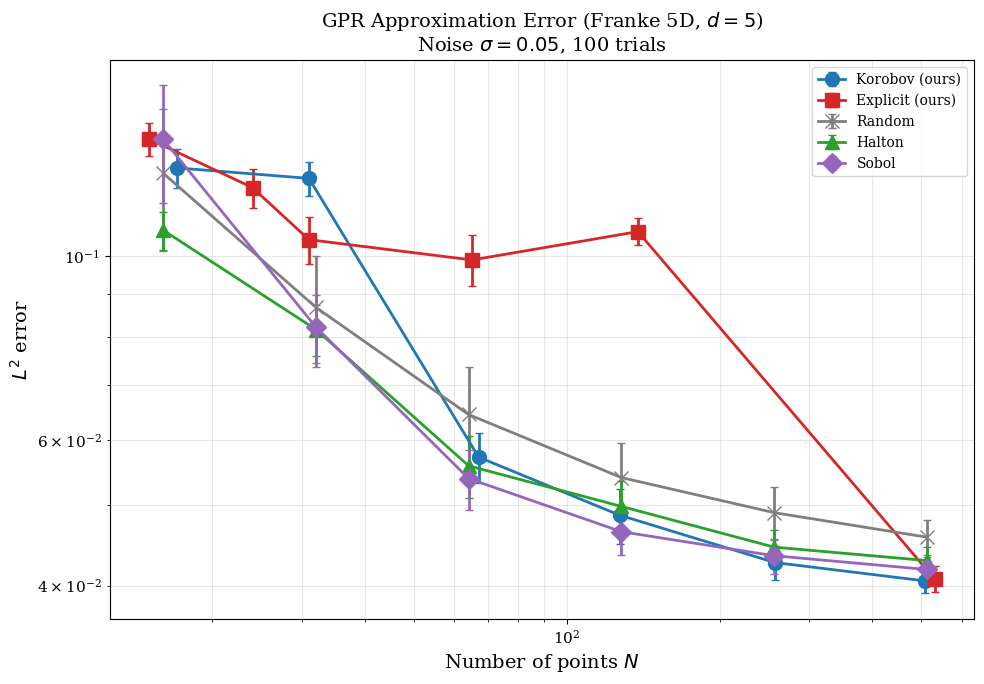

In [71]:
# Plot Franke 5D results
plot_gpr_results(results_franke, d=5, func_name="Franke 5D")

Saved: gpr_error_sum_of_gaussians_5d.pdf, gpr_error_sum_of_gaussians_5d.png


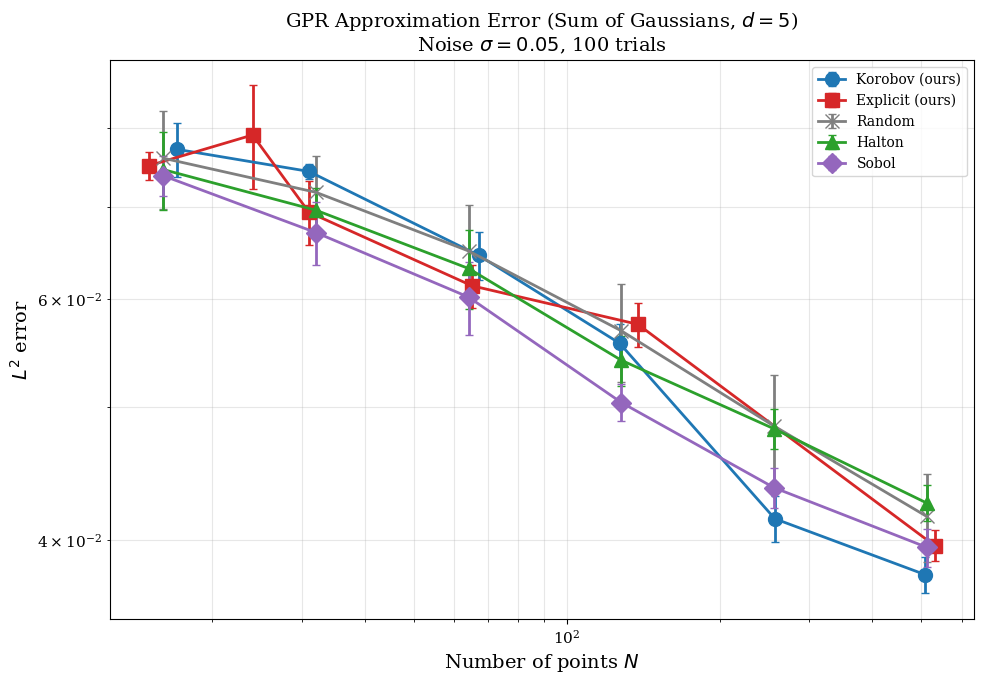

In [ ]:
# Plot Friedman results
plot_gpr_results(results_friedman, d=5, func_name="Friedman")

### 4.1 Combined Plot for All Test Functions

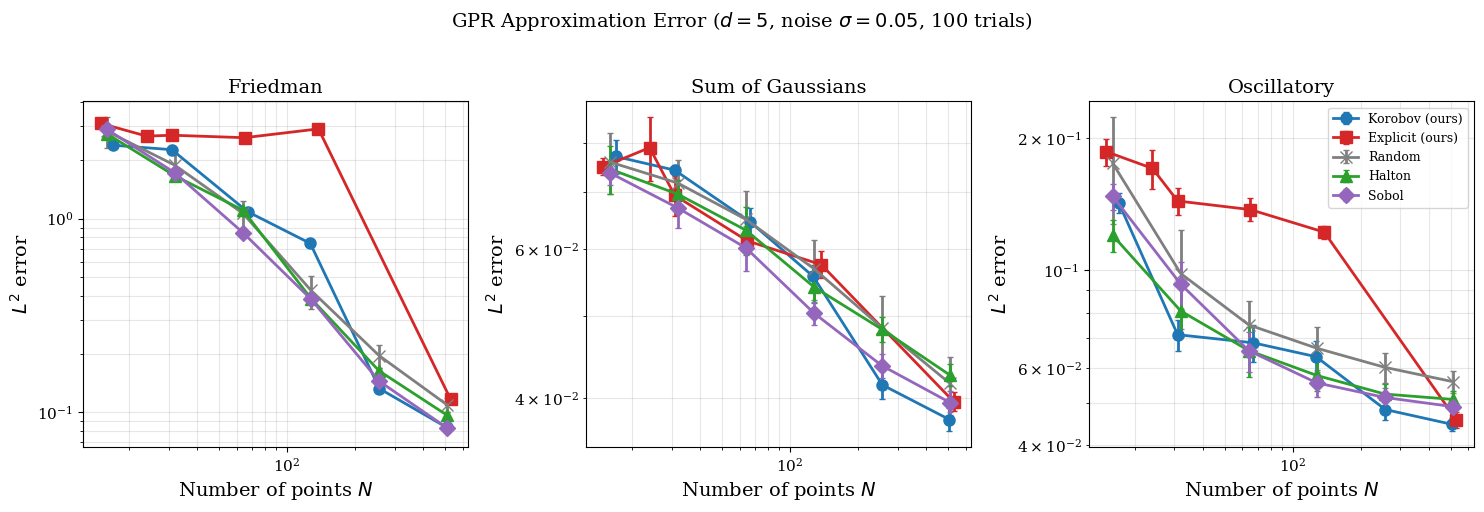


Saved: gpr_error_5d_combined.pdf, gpr_error_5d_combined.png


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

all_results = [
    (results_franke, "Franke 5D"),
    (results_friedman, "Friedman"),
]

styles = {
    'korobov': {'color': '#1f77b4', 'marker': 'o', 'label': 'Korobov (ours)'},
    'explicit': {'color': '#d62728', 'marker': 's', 'label': 'Explicit (ours)'},
    'random': {'color': '#7f7f7f', 'marker': 'x', 'label': 'Random'},
    'halton': {'color': '#2ca02c', 'marker': '^', 'label': 'Halton'},
    'sobol': {'color': '#9467bd', 'marker': 'D', 'label': 'Sobol'},
}

for idx, (results, func_name) in enumerate(all_results):
    ax = axes[idx]
    for method, style in styles.items():
        if results[method]['N']:
            N = np.array(results[method]['N'])
            mean = np.array(results[method]['l2_error_mean'])
            std = np.array(results[method]['l2_error_std'])
            
            ax.errorbar(N, mean, yerr=std,
                       marker=style['marker'], color=style['color'],
                       label=style['label'], linewidth=2, markersize=8,
                       capsize=2, capthick=1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Number of points $N$')
    ax.set_ylabel('$L^2$ error')
    ax.set_title(f'{func_name}')
    ax.grid(True, alpha=0.3, which='both')
    if idx == 1:
        ax.legend(loc='upper right', fontsize=9)

plt.suptitle(f'GPR Approximation Error ($d = 5$, noise $\\sigma = {NOISE_STD}$, {N_TRIALS} trials)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('gpr_error_5d_combined.pdf')
plt.savefig('gpr_error_5d_combined.png', dpi=300)
plt.show()
print("\nSaved: gpr_error_5d_combined.pdf, gpr_error_5d_combined.png")